# Amazon Transcribe

The following blocks can only be run through AWS instances.

After the transcription is completed, data will be saved into a csv file called data.csv under the same directory.

In [ ]:
# run this block if packages not installed
!pip install audio_metadata
!pip install tscribe

In [ ]:
import os
import audio_metadata
import numpy as np
import pandas as pd
import re
import time
import boto3
import s3fs
import tscribe
import json
import urllib.request
import random as rd
import string

config = open("./config/config.conf")
bucket_name = config.read()
config.close()

s3 = boto3.client('s3') #init. s3 storage handle
fs = s3fs.S3FileSystem()
transcribe = boto3.client('transcribe')
supported_format = ["mp3", "flac"] #add on if needed
directory = os.fsencode("./songs/compressed")

## DATAFRAME
data = pd.DataFrame(columns=['Title', 'Artist', 'Bitrate', 'Sample Rate', 'Genre', 'Job Name', 'True Lyrics', 'Transcribed Lyrics', 'Status'])

for count, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    extension = os.path.splitext(filename)[1].replace('.', '')
    if extension in supported_format:
        metadata = audio_metadata.load("./songs/compressed/{}".format(filename))
        try:
            title = metadata['tags']['title'][0].replace('&', '/')
            artist = metadata['tags']['artist'][0].replace('&', '/')
            bitrate = metadata['streaminfo']['bitrate']
            samplerate = metadata['streaminfo']['sample_rate']
            genre = metadata['tags']['genre'][0]
            meta_lyrics = metadata['tags']['usertext'][0]['text'][0].replace("\n", " ").replace("\r", "")
        except:
            print("Error proccessing {}, corrupted metadata".format(filename))
            continue
        
        ### RETRIEVE LYRICS IF NOT ALREADY AVAILABLE ###
        if meta_lyrics == 'null':
            artist_name = artist.replace(' ', '%20')
            song = title.replace(' ', '%20')
            time.sleep(1.5)
            !curl --request GET -o temp_lyrics_raw.json "https://api.lyrics.ovh/v1/$artist_name/$song" > /dev/null 2>&1
            !jq '.lyrics' < temp_lyrics_raw.json > temp_lyrics.json
            lyrics = open("temp_lyrics.json").read()
            true_lyrics = re.sub('\s+', ' ', lyrics.replace('\\r','').replace('\\\'','\'').replace('\\n', ' ').replace('\n','').replace('"','')).replace('\\','')
        else:
            true_lyrics = re.sub('\s+', ' ', meta_lyrics)
            
        #### Check Lyrics Eligibility/Completeness
            # 1. Not null
            # 2. Does not abbreviate, e.g.: [CHOROUSx2], [repeat x2]
            
        if bool(re.search(r"\[.+?\]", true_lyrics)) or true_lyrics == "null":
            print("\n{} by {} dropped\n".format(title, artist))
            continue
        
        #### Remove Parenthensized Content, e.g.: (Aren't I someone? Yeah) I'd (I'd) like to be your answer (Be your answer)
        #### & Formatting
        true_lyrics = re.sub(r"\(.+?\)", "", true_lyrics).replace('.', '').replace(',', '').replace('?', '').replace('!', '').lower()
        #print('{},\n{}'.format(count+1, true_lyrics))
        print(count)
        ### ADD TO S3 BUCKET ###
        s3.upload_file("./songs/compressed/{}".format(filename), bucket_name, filename)
        jobname = os.path.splitext(filename)[0]+str(count)+str(rd.randrange(100,999))
        jobname = re.sub(r"\(.+?\)", "", jobname.replace(" ", ""))
        if not bool(re.match(r"^[0-9a-zA-Z._-]+$", jobname)):
            jobname = ''.join(random.choice(string.ascii_lowercase) for i in range (6)) + str(count)
        
        # AWS Transcribe has limits on tasks running at the same time
        while True:
            try:
                transcribe.start_transcription_job(
                    TranscriptionJobName = jobname,
                    Media = {'MediaFileUri': 's3://{}/{}'.format(bucket_name, filename)},
                    MediaFormat = extension,
                    LanguageCode = 'en-US'
                )
                break
            except:
                continue

            
        
        
        ### DATAFRAME ###
        data = data.append(
                {
                    'Title': title,
                    'Artist': artist,
                    'Bitrate': bitrate,
                    'Sample Rate': samplerate,
                    'Genre': genre,
                    'Job Name': jobname,
                    'True Lyrics': true_lyrics,
                    'Status': "PENDING"
                }, ignore_index = True
            )
print("\n PENDING... \n")
while True:
    for index, row in data.iterrows():
        status = transcribe.get_transcription_job(TranscriptionJobName = row['Job Name'])
        if pd.notna(row['Transcribed Lyrics']):
            continue
        
        elif row['Status'] == "PENDING":
            status = status['TranscriptionJob']['TranscriptionJobStatus']
            if status in ['COMPLETED', 'FAILED']:
                print("\n{} {}".format(row['Job Name'], status), flush = True)
                data.loc[index, 'Status'] = status
        
        elif row['Status'] == "COMPLETED":
            url = status['TranscriptionJob']['Transcript']['TranscriptFileUri']
            result = urllib.request.urlopen(url).read().decode()
            # parse json object
            obj = json.loads(result)
            trans_lyric = obj['results']['transcripts'][0]['transcript']
            # formatting
            trans_lyric = trans_lyric.replace('.', '').replace(',', '').replace('?', '').replace('!', '').lower()
            print(trans_lyric, flush = True)
            data.loc[index, 'Transcribed Lyrics'] = trans_lyric
            print("\n {}/{} Completed \n".format(len(data[data['Status'] == "COMPLETED"]), len(data)))
        else:
            print("Transcription Failed: {}".format(row['Job Name']))
    
    failed_sum = len(data[data['Status'] == 'FAILED'])
    transcribed_sum = sum(pd.isna(data['Transcribed Lyrics']))
    if transcribed_sum == 0 or transcribed_sum == failed_sum:
        break
    #else:
    #    print("Pending...", flush = True)
    
display(data)
data.to_csv("data.csv", index = False)

# Retrieve Song Tempo

In [ ]:
!pip install librosa

In [ ]:
import librosa

# Use a default hop size of 512 samples @ 22KHz ~= 23ms
hop_length = 512

tempo_data = pd.DataFrame(columns=['Title', 'Artist', 'Tempo'])
for count, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    extension = os.path.splitext(filename)[1].replace('.', '')
    if extension in supported_format:
        metadata = audio_metadata.load("./Songs/{}".format(filename))
        print(str(start) + ":\n")
        print("processing...")
        print("at {}".format(filename))
        try:
            title = metadata['tags']['title'][0]
            artist = metadata['tags']['artist'][0]
            print('METADATA DONE')
        except:
            print("Error proccessing {}, corrupted metadata", filename)
            continue
        try:
            y, sr = librosa.load("./Songs/{}".format(filename), sr=22050)
            tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
            print('LIBROSA DONE')
        except:
            print("Error proccessing {}, bad librosa", filename)
            continue
    tempo_data = tempo_data.append(
        {
            'Title': title,
            'Artist': artist,
            'Tempo': tempo
        }, ignore_index = True
    )
    print('CONTINUE...\n')
    start += 1

In [15]:
display(tempo_data)
tempo_data.to_csv("tempo.csv", index = False)

,Title,Artist,Tempo
0,Mad,Ne-Yo,129.199219
1,Happier,Marshmello/Bastille,99.384014
2,Don't,Ed Sheeran,95.703125
3,Single Ladies (Put a Ring on It),Beyoncé,95.703125
4,"No, No, No, Pt. 1",Destiny's Child,60.092660
...,...,...,...
822,What Do You Mean?,Justin Bieber,123.046875
823,Can't Feel My Face,The Weeknd,107.666016
824,Right Round,Flo Rida,123.046875
825,One Kiss,Calvin Harris/Dua Lipa,123.046875


### Calculate The Levenshtein Distance

The following code is retrieved from https://www.datacamp.com/community/tutorials/fuzzy-string-python

In [ ]:
import numpy as np
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [2]:
test = pd.read_csv("data.csv")
test_copy = test.copy()
test_copy = test_copy.dropna(subset=['Transcribed Lyrics', 'True Lyrics'])
test_copy['Accuracy'] = test_copy.apply(lambda x: levenshtein_ratio_and_distance(x['Transcribed Lyrics'], x['True Lyrics'], ratio_calc = True), axis = 1)
display(test_copy)
test_copy.to_csv("test_copy.csv", index = False)

,Title,Artist,Bitrate,Sample Rate,Genre,Job Name,True Lyrics,Transcribed Lyrics,Status,Accuracy
0,Disturbia,Rihanna,32000,11025,Pop,Rihanna-Disturbia0346,bum bum be-dum bum bum be-dum bum bum bum be-...,get out hi mhm yeah oh,COMPLETED,0.017843
1,Who Will Save Your Soul,Jewel,160000,11025,Pop,Jewel-WhoWillSaveYourSoul1327,people living their lives for you on tv they s...,you know yeah,COMPLETED,0.015285
2,"Fastlove, Pt. 1",George Michael,160000,16000,Pop,nugysv2,looking for some education made my way into t...,yeah yeah my friends got their babies there ar...,COMPLETED,0.312564
3,Lean On (feat. MØ / DJ Snake),Major Lazer/MØ/DJ Snake,160000,8000,Electro,hzpwbu3,do you recall not long ago we would walk on th...,here we go for each other the night work it wa...,COMPLETED,0.236101
4,Single Ladies (Put a Ring on It),Beyoncé,160000,11025,Pop,gozwcc4,all the single ladies all the single ladies ...,that would be cool oh,COMPLETED,0.015464
...,...,...,...,...,...,...,...,...,...,...
593,"Let's Ride (feat. Silk ""The Shocker"" Friend / ...","Montell Jordan/Silk ""The Shocker"" Friend/Maste...",96000,44100,R&B,tnuuzu701,you like that huh remember me let's get rowdy ...,uh you remember me ra your mind tell when you ...,COMPLETED,0.345957
594,Turnin Me On (feat. Lil Wayne),Keri Hilson/Lil Wayne,64000,44100,R&B,xnuyaa702,please don't turn me off yeah like this where ...,yeah,COMPLETED,0.003009
595,Twisted,Keith Sweat,160000,44100,Dance/Rock,KeithSweat-Twisted703495,oh yeah baby you got to make your mind up yeah...,oh yeah baby you got to make your mind up yeah...,COMPLETED,0.281361
596,Hot Girl Summer (feat. Nicki Minaj / Ty Dolla ...,Megan Thee Stallion/Ty Dolla $ign/Nicki Minaj,96000,11025,Rap/Hip Hop,iiinbu704,real hot girl shit real real ass bitch give a...,focus what did he say it is but it it's a hot ...,COMPLETED,0.234610


### Merge Tempo data and Accuracy data

Also subset the dataframe by the top 7 genre

In [14]:
import re
import pandas as pd
df = pd.merge(tempo_data, test_copy, on = 'Title', how = 'right')
df = df[['Title', 'Artist_y', 'Tempo', 'Bitrate', 'Sample Rate', 'Genre', 'Accuracy']]
df = df.rename(columns = {'Artist_y': 'Artist', 'Sample Rate': 'SampleRate'})
for index, row in df.iterrows():
    if bool(re.search(r"(Rap)|(Hip Hop)", row['Genre'])):
        df.loc[index, 'Genre'] = 'Hip Hop'
    if bool(re.search(r"Dance", row['Genre'])):
        df.loc[index, 'Genre'] = 'Dance'
    if bool(re.search(r"R&B", row['Genre'])):
        df.loc[index, 'Genre'] = 'R&B'
    if bool(re.search(r"Rock", row['Genre'])):
        df.loc[index, 'Genre'] = 'Rock'
    if bool(re.search(r"Pop", row['Genre'])):
        df.loc[index, 'Genre'] = 'Pop'
top_genre = df['Genre'].value_counts().index[:7]
df_genre_filtered = df[df['Genre'].isin(top_genre)].copy()

In [77]:
df['Genre'].value_counts()

Pop                        267
Hip Hop                    190
R&B                         77
Alternative                 28
Rock                        20
Films/Games/Film Scores      9
Dance                        7
Reggae                       2
Asian Music                  2
Latin Music                  1
Folk                         1
Singer & Songwriter          1
Kids                         1
Electro                      1
Name: Genre, dtype: int64

In [82]:
df_genre_filtered['Genre'].value_counts()

Pop                        267
Hip Hop                    190
R&B                         77
Alternative                 28
Rock                        20
Films/Games/Film Scores      9
Dance                        7
Name: Genre, dtype: int64

In [15]:
df_genre_filtered.describe()

,Tempo,Bitrate,SampleRate,Accuracy
count,546.000000,598.000000,598.000000,598.000000
mean,120.483424,125484.949833,20660.158863,0.405519
std,27.436116,62560.782699,13339.743575,0.265469
min,60.092660,24000.000000,8000.000000,0.001790
25%,99.384014,64000.000000,11025.000000,0.175748
50%,117.453835,128000.000000,16000.000000,0.387860
75%,135.999178,160000.000000,22050.000000,0.643084
max,198.768029,320000.000000,44100.000000,0.939430


# Preliminary Analysis

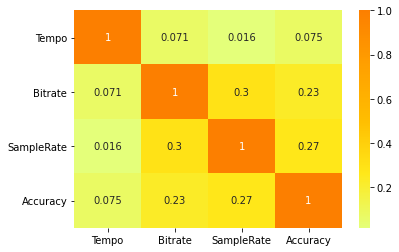

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# correlation plot
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

First, let's check the dependent variable `Accuracy` that we are going to analyze:

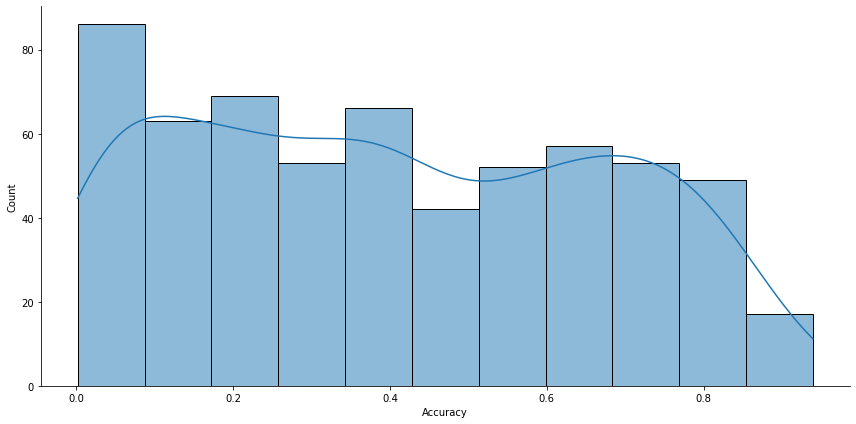

In [29]:
sns.displot(x = 'Accuracy', data = df, aspect = 2, height = 6, kde = True);

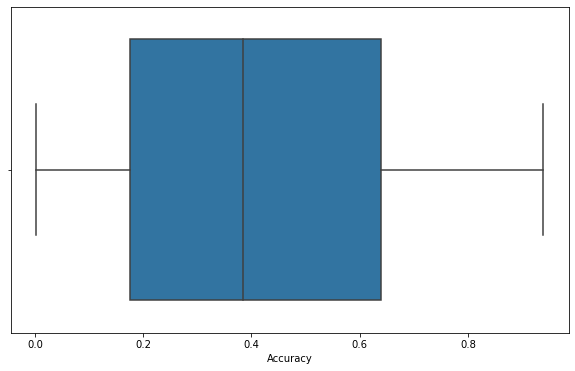

In [30]:
# Boxplot of target attribute
plt.figure(figsize = (10,6))
sns.boxplot(x = 'Accuracy', data = df);

 Based on the graph above, we can see that there is no outliers, we can proceed to our analysis.

In [31]:
df['Sample Rate'].unique()
df['Sample Rate'].value_counts()

44100    132
8000     130
11025    122
16000    112
22050    111
Name: Sample Rate, dtype: int64

In [32]:
df['Bitrate'].unique()
df['Bitrate'].value_counts()

160000    250
128000     77
96000      73
32000      57
40000      34
64000      26
256000     23
56000      22
192000     17
24000      17
320000     11
Name: Bitrate, dtype: int64

## Regression

In [33]:
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

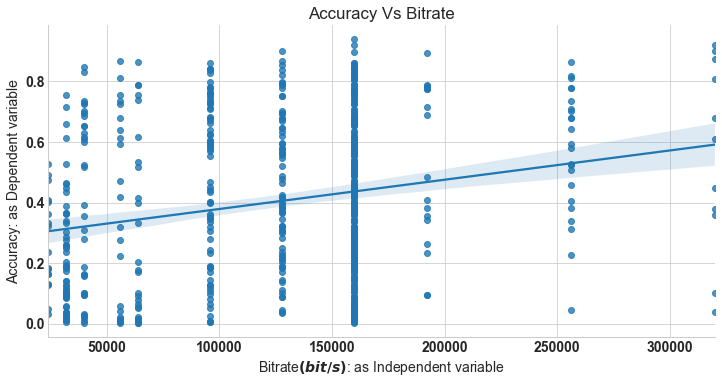

In [38]:
sns.lmplot(x='Bitrate',y='Accuracy',data=df,aspect=2,height=5)
plt.xlabel('Bitrate$(bit/s)$: as Independent variable')
plt.ylabel('Accuracy: as Dependent variable')
plt.title('Accuracy Vs Bitrate');

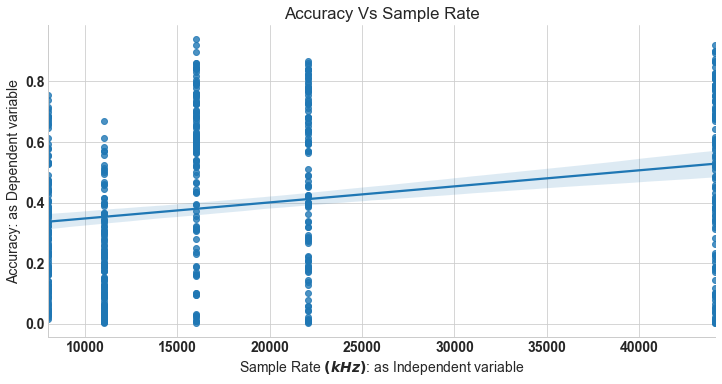

In [39]:
sns.lmplot(x='Sample Rate',y='Accuracy',data=df,aspect=2,height=5)
plt.xlabel('Sample Rate $(kHz)$: as Independent variable')
plt.ylabel('Accuracy: as Dependent variable')
plt.title('Accuracy Vs Sample Rate');

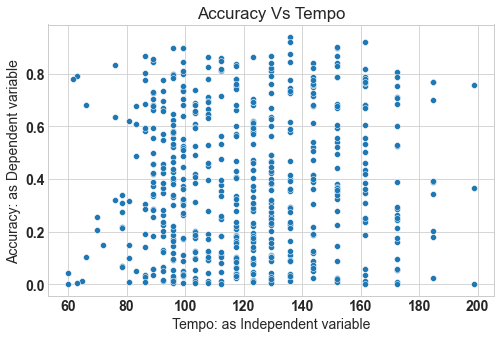

In [40]:
sns.scatterplot(x='Tempo',y='Accuracy',data=df);
plt.xlabel('Tempo: as Independent variable')
plt.ylabel('Accuracy: as Dependent variable')
plt.title('Accuracy Vs Tempo');

## Categorical Data

Although from the graph above, we might visually get a linear relation ship between Birtate/ Sample Rate and Accuracy, **Birtate** or **Sample Rate** are not continuous but are categorical.



In [61]:
df['Sample Rate'].unique()
df['Sample Rate'].value_counts()

44100    130
8000     128
11025    121
16000    110
22050    109
Name: Sample Rate, dtype: int64

In [62]:
df['Bitrate'].unique()
df['Bitrate'].value_counts()

160000    247
128000     76
96000      73
32000      55
40000      33
64000      25
256000     23
56000      22
24000      17
192000     16
320000     11
Name: Bitrate, dtype: int64

Therefore, we can create new categorical values for them.

In [47]:
cond_bit = [
    (df['Bitrate'] == 320000),
    (df['Bitrate'] == 256000),
    (df['Bitrate'] == 192000),
    (df['Bitrate'] == 160000),
    (df['Bitrate'] == 128000),
    (df['Bitrate'] ==  96000),
    (df['Bitrate'] ==  64000),
    (df['Bitrate'] ==  56000),
    (df['Bitrate'] ==  40000),
    (df['Bitrate'] ==  32000),
    (df['Bitrate'] ==  24000)
    ]

cond_samp = [
    (df['Sample Rate'] == 44100),
    (df['Sample Rate'] == 22050),
    (df['Sample Rate'] == 16000),
    (df['Sample Rate'] == 11025),
    (df['Sample Rate'] ==  8000)
    ]

# create a list of the values we want to assign for each condition
val_bit = ['320 kbit/s','256 kbit/s','192 kbit/s','160 kbit/s','128 kbit/s','96 kbit/s','64 kbit/s','56 kbit/s','40 kbit/s','32 kbit/s','24 kbit/s']

val_samp = ['8 kHz', '11.025 kHz', '16 kHz', '22.05 kHz', '44.1 kHz']

# create a new column and use np.select to assign values to it using our lists as arguments
df['BR_kbit'] = np.select(cond_bit, val_bit)
df['SR_kHz'] = np.select(cond_samp, val_samp)

# display updated DataFrame
df[['Title', 'Bitrate','BR_kbit', 'Sample Rate', 'SR_kHz', 'Genre', 'Accuracy']]

,Title,Bitrate,BR_kbit,Sample Rate,SR_kHz,Genre,Accuracy
0,Disturbia,32000,32 kbit/s,11025,22.05 kHz,Pop,0.017843
1,Who Will Save Your Soul,160000,160 kbit/s,11025,22.05 kHz,Pop,0.015285
2,"Fastlove, Pt. 1",160000,160 kbit/s,16000,16 kHz,Pop,0.312564
3,Lean On (feat. MØ / DJ Snake),160000,160 kbit/s,8000,44.1 kHz,Electro,0.236101
4,Single Ladies (Put a Ring on It),160000,160 kbit/s,11025,22.05 kHz,Pop,0.015464
...,...,...,...,...,...,...,...
593,"Let's Ride (feat. Silk ""The Shocker"" Friend / ...",96000,96 kbit/s,44100,8 kHz,R&B,0.345957
594,Turnin Me On (feat. Lil Wayne),64000,64 kbit/s,44100,8 kHz,R&B,0.003009
595,Twisted,160000,160 kbit/s,44100,8 kHz,Dance/Rock,0.281361
596,Hot Girl Summer (feat. Nicki Minaj / Ty Dolla ...,96000,96 kbit/s,11025,22.05 kHz,Rap/Hip Hop,0.234610


Now, we can have the following illustrations based on the variables we have above.

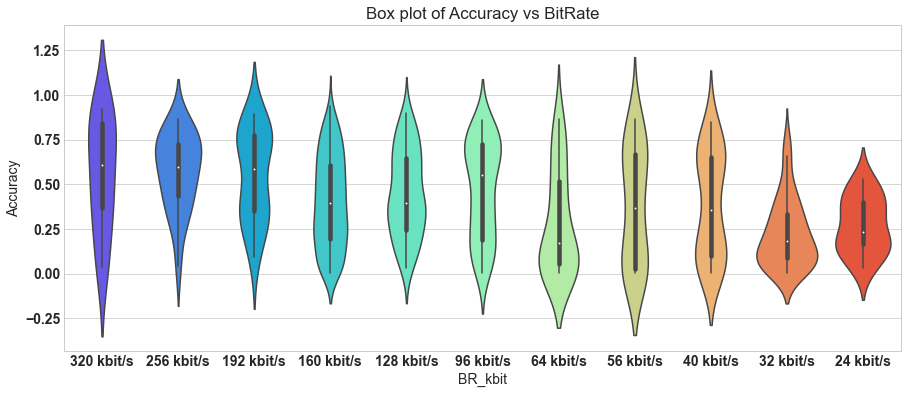

In [63]:
plt.figure(figsize=(15,6))
sns.violinplot(x='BR_kbit', y='Accuracy',
            order=val_bit, data=df, palette='rainbow')
plt.title('Box plot of Accuracy vs BitRate');

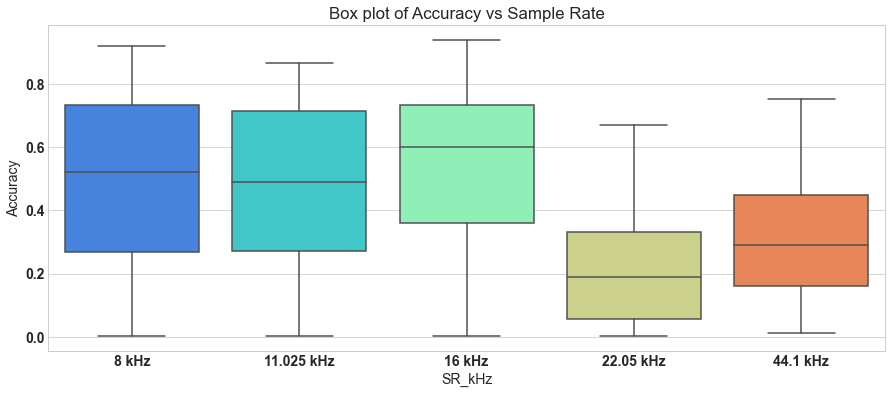

In [51]:
plt.figure(figsize=(15,6))
sns.boxplot(x='SR_kHz', y='Accuracy',
            order=val_samp, data=df, palette='rainbow')
plt.title('Box plot of Accuracy vs Sample Rate');

In [59]:
top5 = df['Genre'].value_counts().index[:5]
df1 = df[df['Genre'].isin(top5)]
df1

,Title,Artist,Bitrate,Sample Rate,Genre,Job Name,True Lyrics,Transcribed Lyrics,Status,Accuracy,BR_kbit,SR_kHz
0,Disturbia,Rihanna,32000,11025,Pop,Rihanna-Disturbia0346,bum bum be-dum bum bum be-dum bum bum bum be-...,get out hi mhm yeah oh,COMPLETED,0.017843,32 kbit/s,22.05 kHz
1,Who Will Save Your Soul,Jewel,160000,11025,Pop,Jewel-WhoWillSaveYourSoul1327,people living their lives for you on tv they s...,you know yeah,COMPLETED,0.015285,160 kbit/s,22.05 kHz
2,"Fastlove, Pt. 1",George Michael,160000,16000,Pop,nugysv2,looking for some education made my way into t...,yeah yeah my friends got their babies there ar...,COMPLETED,0.312564,160 kbit/s,16 kHz
4,Single Ladies (Put a Ring on It),Beyoncé,160000,11025,Pop,gozwcc4,all the single ladies all the single ladies ...,that would be cool oh,COMPLETED,0.015464,160 kbit/s,22.05 kHz
5,Lay Me Down,Sam Smith,32000,8000,Pop,SamSmith-LayMeDown5950,yes i do i believe that one day i will be wher...,i do i believe one day i will be where i was r...,COMPLETED,0.463604,32 kbit/s,44.1 kHz
...,...,...,...,...,...,...,...,...,...,...,...,...
592,Thunder,Imagine Dragons,160000,8000,Pop,ImagineDragons-Thunder700724,just a young gun with the quick fuse i was upt...,i was dreaming bigger things and bottles not a...,COMPLETED,0.176645,160 kbit/s,44.1 kHz
593,"Let's Ride (feat. Silk ""The Shocker"" Friend / ...","Montell Jordan/Silk ""The Shocker"" Friend/Maste...",96000,44100,R&B,tnuuzu701,you like that huh remember me let's get rowdy ...,uh you remember me ra your mind tell when you ...,COMPLETED,0.345957,96 kbit/s,8 kHz
594,Turnin Me On (feat. Lil Wayne),Keri Hilson/Lil Wayne,64000,44100,R&B,xnuyaa702,please don't turn me off yeah like this where ...,yeah,COMPLETED,0.003009,64 kbit/s,8 kHz
596,Hot Girl Summer (feat. Nicki Minaj / Ty Dolla ...,Megan Thee Stallion/Ty Dolla $ign/Nicki Minaj,96000,11025,Rap/Hip Hop,iiinbu704,real hot girl shit real real ass bitch give a...,focus what did he say it is but it it's a hot ...,COMPLETED,0.234610,96 kbit/s,22.05 kHz


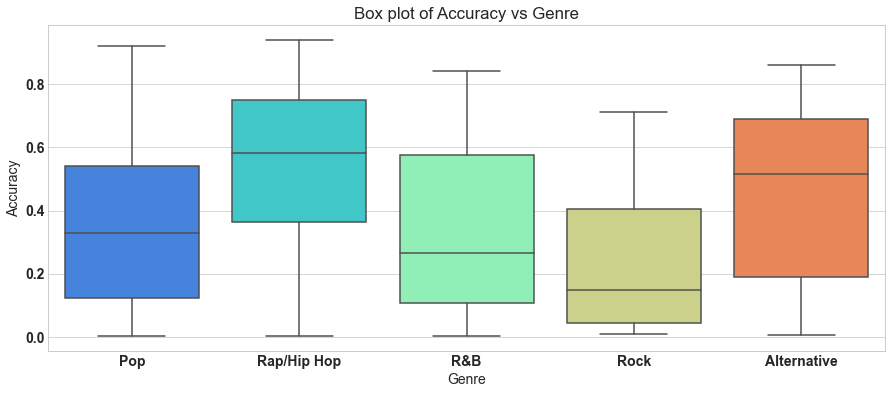

In [60]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Genre', y='Accuracy',
            data=df1, palette='rainbow')
plt.title('Box plot of Accuracy vs Genre');

## Preliminary Conclusion

- Bitrate:

Visually, Bitrate has a positive correlation with accuracy in a way that `transcribe` tends to have a higher accuracy if the input has a higher bitrate.

- Sample Rate:

From the illustration, it is difficult to find a relationship between Sample Rate and Accuracy. But we can see that input with relative lower Sample Rate (8 kHz, 11.025 kHz, 16 kHz) has a higher accuracy than those with higher Sample Rate (22.05 kHz, 44.1 kHz).

- Genre:

Different genres seem to have a large impact for transcribe accuracy.

- Tempo:

It seems like there is no correlation between tempo and accuracy.


# Multiple Linear Regression Analysis

In [99]:
# Bitrate, Sample Rate / 10000 for easier regression coefficient representaiton
df_genre_filtered.loc[:, 'SampleRate_by10k'] = df_genre_filtered['SampleRate'].div(10000)
df_genre_filtered.loc[:, 'Bitrate_by10k'] = df_genre_filtered['Bitrate'].div(10000)
df_genre_filtered.describe()

,Tempo,Bitrate,SampleRate,Accuracy,SampleRate_by10k,Bitrate_by10k
count,546.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,120.483424,125484.949833,20660.158863,0.405519,2.066016,12.548495
std,27.436116,62560.782699,13339.743575,0.265469,1.333974,6.256078
min,60.092660,24000.000000,8000.000000,0.001790,0.800000,2.400000
25%,99.384014,64000.000000,11025.000000,0.175748,1.102500,6.400000
50%,117.453835,128000.000000,16000.000000,0.387860,1.600000,12.800000
75%,135.999178,160000.000000,22050.000000,0.643084,2.205000,16.000000
max,198.768029,320000.000000,44100.000000,0.939430,4.410000,32.000000


In [ ]:
#!pip install stargazer
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

model_full = smf.ols(formula = 'Accuracy ~ Bitrate_by10k + SampleRate_by10k + Tempo + Genre', data = df_genre_filtered)
model_full = model_full.fit()

In [ ]:
model_abbr = smf.ols(formula = 'Accuracy ~ Bitrate_by10k + SampleRate_by10k + Tempo', data = df_genre_filtered)
model_abbr = model_abbr.fit()

In [102]:
st=Stargazer([model_abbr,model_full])
st.rename_covariates({
    'Genre[T.Dance]':"Genre (Dance)",
    'Genre[T.Films/Games/Film Scores]':"Genre (Films/Games/Film Scores)",
    'Genre[T.Hip Hop]':"Genre (Hip Hop)",
    'Genre[T.Pop]':"Genre (Pop)",
    'Genre[T.R&B]':"Genre (R&B)",
    'Genre[T.Rock]':"Genre (Rock)",
    'SampleRate_by10k':"Sample Rate",
    'Bitrate_by10k':'Bitrate'
})
st.covariate_order(['Bitrate_by10k', 'SampleRate_by10k', 'Tempo', 'Genre[T.Dance]',
                    'Genre[T.Hip Hop]', 'Genre[T.Pop]', 'Genre[T.R&B]', 'Genre[T.Rock]', 'Genre[T.Films/Games/Film Scores]', 'Intercept'])
from IPython.core.display import HTML
HTML(st.render_html()) 